### Problem Definition

<img src="store segmentation.jpg">

#### Data Dictionary

### Creation of base dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt

#### Merging Multiple Datasets

In [2]:
df=pd.read_csv(r"C:\Users\admin\Desktop\Python\Pandas datasets\rossmann-store-sales\train.csv")

C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [4]:
df.shape

(1017209, 9)

In [5]:
# created a backup dataset for doing interpretations at the end
base_dataset_backup=df

### Pre Processing

#### Memory Management



In [6]:
""" iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
"""
start_mem = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    else:
        df[col] = df[col].astype('category')

end_mem = df.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))    

Memory usage of dataframe is 69.85 MB
Memory usage after optimization is: 14.60 MB
Decreased by 79.1%


In [7]:
df.dtypes

Store               int16
DayOfWeek            int8
Date             category
Sales               int32
Customers           int16
Open                 int8
Promo                int8
StateHoliday     category
SchoolHoliday        int8
dtype: object

In [8]:
# group by is done at store level to get unique store level data
#As its a k-means clustering we r extracting only continuous columns
#i,e Sales & Customers
base_df=df.groupby("Store").sum()[['Sales','Customers']]

In [9]:
#in base_df dataset store is as index
base_df.head(2)

,Sales,Customers
Store,,
1,3716854,440523.0
2,3883858,457855.0


In [10]:
# by giving reset_index store turns to column and a new index will be generated
base_df.reset_index(inplace=True)

In [11]:
base_df.head()

,Store,Sales,Customers
0,1,3716854,440523.0
1,2,3883858,457855.0
2,3,5408261,584310.0
3,4,7556507,1036254.0
4,5,3642818,418588.0


In [12]:
base_df.shape

(1115, 3)

#### Null value treatment


In [21]:
base_df.isna().sum()

Store        0
Sales        0
Customers    0
dtype: int64

In [14]:
# As  there r no null values no null value tretment is required
# As it is a unsupervised algo i,e K-Means 
# we neednot subset the data into categorical and Contionus
# def null_values(base_dataset):
#     print(base_dataset.isna().sum())
    ## null value percentage     
#     null_value_table=(base_dataset.isna().sum()/base_dataset.shape[0])*100
    ## null value percentage beyond threshold drop , else treat the columns 
    
#     retained_columns=null_value_table[null_value_table<int(input())].index
    # if any variable as null value greater than input(like 30% of the data) 
    #value than those variable are consider as drop
#     drop_columns=null_value_table[null_value_table>int(input())].index
#     base_dataset.drop(drop_columns,axis=1,inplace=True)
#     len(base_dataset.isna().sum().index)
#     cont=base_dataset.describe().columns
#     cat=[i for i in base_dataset.columns if i not in base_dataset.describe().columns]
#     for i in cat:
#         base_dataset[i].fillna(base_dataset[i].value_counts().index[0],inplace=True)
#     for i in cont:
#         base_dataset[i].fillna(base_dataset[i].median(),inplace=True)
#     print(base_dataset.isna().sum())
#     return base_dataset,cat,cont

In [15]:
# Null Value Function Call
# base_Df_nullvalues_treated,cat,cont=null_values(base_df)

In [16]:
base_df.columns

Index(['Store', 'Sales', 'Customers'], dtype='object')

#### Outlier treatment


In [17]:
"""We have to perform outliers on all the continous features and 
after identifying the outliers take a call to client wheather to treat, 
drop or keep it as the data itself becoz sometimes they may be data also"""

'We have to perform outliers on all the continous features and \nafter identifying the outliers take a call to client wheather to treat, \ndrop or keep it as the data itself becoz sometimes they may be data also'

(array([       0.,  2500000.,  5000000.,  7500000., 10000000., 12500000.,
        15000000., 17500000., 20000000., 22500000.]),
 <a list of 10 Text xticklabel objects>)

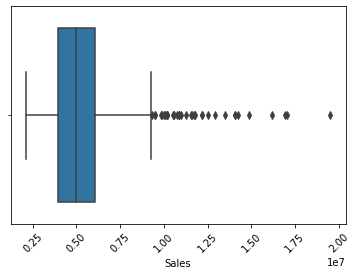

In [18]:
import seaborn as sns
sns.boxplot(base_df['Sales'])
plt.xticks(rotation=45)

(array([      0.,  500000., 1000000., 1500000., 2000000., 2500000.,
        3000000., 3500000.]), <a list of 8 Text xticklabel objects>)

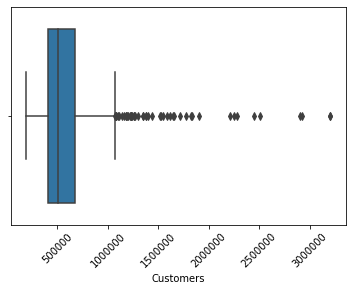

In [19]:
import seaborn as sns
sns.boxplot(base_df['Customers'])
plt.xticks(rotation=45)

In [20]:
# def outliers_transform(base_dataset):
#     for i in base_dataset.var().sort_values(ascending=False).index[1:10]:
#         x=np.array(base_dataset[i])
#         qr1=np.quantile(x,0.25)
#         qr3=np.quantile(x,0.75)
#         iqr=qr3-qr1
#         utv=qr3+(1.5*(iqr))
#         ltv=qr1-(1.5*(iqr))
#         y=[]
# """Based on clients input(ltv,utv) run the below code """
#         for p in x:
#             if p <ltv or p>utv:
#                 y.append(np.median(x))
#             else:
#                 y.append(p)
#         base_dataset[i]=y

IndentationError: unexpected indent (<ipython-input-20-d3940299aec2>, line 11)

####  Label encoders


In [ ]:
# """ since there r no categorical data in the categorical columns 
# we neednot perform the label encoders"""
# # Label encoders r used for converting categorical col to numeric col
# from sklearn.preprocessing import LabelEncoder
# def label_encoders(data,cat):
#     le=LabelEncoder()
#     for i in cat:
#         le.fit(data[i])
#         x=le.transform(data[i])
#         data[i]=x
#     return data

#### Min max scalar


In [22]:
"""MinMaxScaler to make all the columns to same scale(Normalisation) 
For all the clustering proj we use MinMaxScaler and it is performed on 
continous col"""
"""mn.transform() The moment we run transform it becomes a numpy array"""
"""dat1=pd.DataFrame(x)Converting numpy array into DataFrame"""
"""dat1.columns=data.columnsAssigning the col names"""
from sklearn.preprocessing import MinMaxScaler
#     MinMaxScaler(data):
mn=MinMaxScaler()
mn.fit(base_df)
x=mn.transform(base_df)
data1=pd.DataFrame(x)
data1.columns=base_df.columns
base_df=data1
#     return data


In [24]:
base_df.head()

,Store,Sales,Customers
0,0.000000,0.092086,0.083797
1,0.000898,0.101683,0.089539
2,0.001795,0.189279,0.131433
3,0.002693,0.312724,0.281159
4,0.003591,0.087832,0.076530


#### Standard scalar


In [ ]:
"""StandardScaler is used for supervised ML Algo
This is not required for ur unsupervised algo"""
# from sklearn.preprocessing import StandardScaler
# def StandardScaler(data):
#     le=StandardScaler()
#     le.fit(data)
#     x=le.transform(data)
#     dat1=pd.DataFrame(x)
#     dat1.columns=data.columns
#     data=data1
#     return data


#### Univariate analysis (EDA)


In [ ]:
"""Univariate analysis is study of single variable"""

#### Bivariate analysis (EDA)


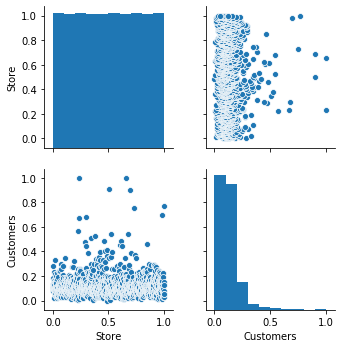

In [26]:
sns.pairplot(base_df[['Store','Customers']])

#### Dimensionality Reduction

### Model Building

#### Identifying the right number of clusters

In [28]:
# Using the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt

def kelbow(df,k):
    from sklearn.cluster import KMeans
    x = []
    for i in range(1,k):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(df)
        x.append(kmeans.inertia_)

    plt.plot(range(1,k), x)
    plt.title('The elbow method')
    plt.xlabel('The number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return x

#### Clustering

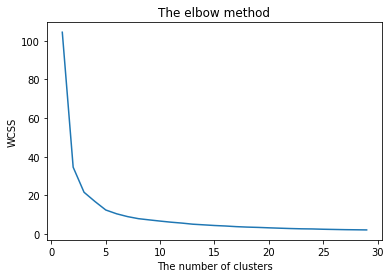

[104.43163937175504,
 34.61677072898935,
 21.652895014372714,
 16.88805721656073,
 12.476259868546643,
 10.506442945523528,
 9.062807615563418,
 7.992735813701967,
 7.352898216660254,
 6.736968911094021,
 6.168341131952122,
 5.700848452865069,
 5.130720355730087,
 4.796571099485727,
 4.454095821956557,
 4.1987838508230135,
 3.86495830172355,
 3.6309438141551924,
 3.4706271931379225,
 3.255204139659297,
 3.062951393045591,
 2.881104303394384,
 2.740817872818769,
 2.6697046789382424,
 2.5150033410918424,
 2.4073793300738227,
 2.3019421138084373,
 2.2383466778325767,
 2.1695428060341433]

In [29]:
kelbow(base_df[['Store','Customers']],30)

In [30]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=5)
km.fit(base_df[['Sales','Customers']])
len(km.predict(base_df[['Sales','Customers']]))

1115

In [31]:
base_df.shape

(1115, 3)

In [32]:
"""Based on distance it flags the data(rows) with clusters(k)"""
km.predict(base_df[['Sales','Customers']])

array([0, 0, 3, ..., 3, 4, 3])

In [33]:
base_df['clusters']=km.predict(base_df[['Sales','Customers']])

In [34]:
base_df.head(2)

,Store,Sales,Customers,clusters
0,0.000000,0.092086,0.083797,0
1,0.000898,0.101683,0.089539,0


#### Visualizing the clusters

In [35]:
""".value_counts() gives the count of unique values present in the column"""
base_df['clusters'].value_counts()

3    437
0    403
2    213
1     48
4     14
Name: clusters, dtype: int64

In [37]:
"""Grouping all the data(rows) with flag 2 into base_df_c1 """
base_df_c1=base_df[base_df['clusters']==2]

In [38]:
"""Calculating the mean for sales of base_df_c1"""
base_df_c1['Sales'].mean()

0.27879194367177024

In [39]:
base_df_c1.shape

(213, 4)

In [40]:
"""Comparing each value of sale column belonging to cluster1 with mean value
of cluster1 (7106094.466367713) filtering the rows wch are less than
mean i.e.,out of 220...188 are less than mean value"""
base_df_c1[base_df_c1['Sales']<base_df_c1['Sales'].mean()]['Store'].values.shape

(115,)

In [41]:
potential_stores=base_df_c1[base_df_c1['Sales']<base_df_c1['Sales'].mean()]

In [42]:
potential_stores.shape[0]

115

In [43]:
"""Sum of all the values(potential_stores['Sales']-base_df_c1['Sales'].mean())/Total 
no of rows(potential_stores.shape[0])
abs gives the absolut value"""
(abs(potential_stores['Sales']-base_df_c1['Sales'].mean()).sum())/potential_stores.shape[0]

0.03060739888470342

#### Interpreting the clusters

### Model Validation

#### Checking the accuracy of clusters

In [49]:
"""this is to Display the values with 2 float points"""
pd.options.display.float_format = '{:.2f}'.format

In [50]:
base_df.head()

,Store,Sales,Customers,clusters
0,0.00,0.09,0.08,0
1,0.00,0.10,0.09,0
2,0.00,0.19,0.13,3
3,0.00,0.31,0.28,2
4,0.00,0.09,0.08,0


In [52]:
"""Here we r grouping the dataset based on clusters and finding the descriptive statistics for each column """
pd.DataFrame(base_df.groupby("clusters").describe()).T

clusters             0     1      2      3     4
Store     count 403.00 48.00 213.00 437.00 14.00
          mean    0.49  0.52   0.52   0.49  0.54
          std     0.29  0.24   0.29   0.29  0.26
          min     0.00  0.02   0.00   0.00  0.22
          25%     0.23  0.38   0.28   0.25  0.31
          50%     0.50  0.48   0.54   0.49  0.51
          75%     0.73  0.69   0.78   0.75  0.69
          max     1.00  0.96   1.00   1.00  1.00
Sales     count 403.00 48.00 213.00 437.00 14.00
          mean    0.09  0.43   0.28   0.18  0.67
          std     0.03  0.09   0.04   0.03  0.17
          min     0.00  0.25   0.17   0.10  0.41
          25%     0.06  0.36   0.25   0.15  0.56
          50%     0.09  0.42   0.27   0.18  0.67
          75%     0.11  0.48   0.30   0.20  0.79
          max     0.15  0.69   0.40   0.26  1.00
Customers count 403.00 48.00 213.00 437.00 14.00
          mean    0.06  0.34   0.19   0.12  0.72
          std     0.03  0.08   0.04   0.03  0.18
          min     0.00  0.17   0.11   0.05  0.48
          25%     0.04  0.28   0.16   0.09  0.55
          50%     0.06  0.33   0.19   0.12  0.69
          75%     0.08  0.37   0.22   0.14  0.87
          max     0.13  0.53   0.38   0.26  1.00

#### Accuracy metrics

In [54]:
base_df[base_df['clusters']==1].shape

(48, 4)

In [55]:
"""Entropy is b/w 0 to 1. if the value is <0.5 its a good cluster if it is 1 its a bad cluster
Entropy is for getting acurracy score. Entropy is based on Probability calculation. Entropy is a homogenous mixture
As ur entropy value is 0.1 its a good cluster
In the same way cal the entropy for all the cluster with sales and customer and take the avg as the score"""
import math
total_entropy=[]
for i in base_df[base_df['clusters']==1]['Sales']:
    num= list(base_df[base_df['clusters']==1]['Sales'].values).count(i)
    den= base_df[base_df['clusters']==1]['Sales'].shape[0]
    total_entropy.append(((num/den)*(1/math.log(num/den,2))))
    

total_entropy=np.array(total_entropy).sum()

total_entropy=-(total_entropy)

total_entropy

0.17905223175104135

In [59]:
import math
total_entropy=[]
for i in base_df[base_df['clusters']==1]['Customers']:
    num= list(base_df[base_df['clusters']==1]['Customers'].values).count(i)
    den= base_df[base_df['clusters']==1]['Customers'].shape[0]
    total_entropy.append(((num/den)*(1/math.log(num/den,2))))
    

total_entropy=np.array(total_entropy).sum()

total_entropy=-(total_entropy)

total_entropy

0.17905223175104135

In [57]:
plt.scatter

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>

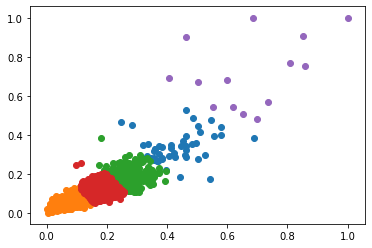

In [58]:
plt.scatter(base_df[base_df['clusters']==1]['Sales'],base_df[base_df['clusters']==1]['Customers'])
plt.scatter(base_df[base_df['clusters']==0]['Sales'],base_df[base_df['clusters']==0]['Customers'])
plt.scatter(base_df[base_df['clusters']==2]['Sales'],base_df[base_df['clusters']==2]['Customers'])
plt.scatter(base_df[base_df['clusters']==3]['Sales'],base_df[base_df['clusters']==3]['Customers'])
plt.scatter(base_df[base_df['clusters']==4]['Sales'],base_df[base_df['clusters']==4]['Customers'])

### Model Finetuning

#### improving the clusters by selecting the better criteria

### Model Deployment

#### flask api to access the model deployment 